In [1]:

%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display
from pyvis.network import Network

import pickle
import os

np.random.seed(42)

In [2]:
datasets = f'../data/connectomes/'
connectomes = os.listdir(datasets)

In [3]:
for i in range(len(connectomes)):
    real_graph = nx.read_graphml(datasets + connectomes[i])
    print(connectomes[i])
    print("\t i:", i)
    print("\tNodes:", real_graph.number_of_nodes())
    print("\tEdges:", real_graph.number_of_edges())
    print()


p.pacificus_neural.synaptic_2.graphml
	 i: 0
	Nodes: 50
	Edges: 611

rhesus_cerebral.cortex_1.graphml
	 i: 1
	Nodes: 91
	Edges: 1989

rattus.norvegicus_brain_1.graphml
	 i: 2
	Nodes: 503
	Edges: 27667

mixed.species_brain_1.graphml
	 i: 3
	Nodes: 65
	Edges: 1139

mouse_visual.cortex_2.graphml
	 i: 4
	Nodes: 195
	Edges: 214

rattus.norvegicus_brain_2.graphml
	 i: 5
	Nodes: 503
	Edges: 30088

p.pacificus_neural.synaptic_1.graphml
	 i: 6
	Nodes: 54
	Edges: 511

mouse_visual.cortex_1.graphml
	 i: 7
	Nodes: 29
	Edges: 44

rattus.norvegicus_brain_3.graphml
	 i: 8
	Nodes: 496
	Edges: 33020

rhesus_interareal.cortical.network_2.graphml
	 i: 9
	Nodes: 93
	Edges: 2667

rhesus_brain_1.graphml
	 i: 10
	Nodes: 242
	Edges: 4090

mouse_retina_1.graphml
	 i: 11
	Nodes: 1123
	Edges: 577350

kasthuri_graph_v4.graphml
	 i: 12
	Nodes: 1029
	Edges: 1700

mouse_brain_1.graphml
	 i: 13
	Nodes: 213
	Edges: 21807

drosophila_medulla_1.graphml
	 i: 14
	Nodes: 1781
	Edges: 33641

c.elegans.herm_pharynx_1.graphml

# Plot and Spectrum and model selection for different connectomes

In [4]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   # TODO: improve the estimation of d
   # d=0

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )
   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

In [5]:
def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

# Analysing one connectome per time

In [6]:
i = 1
print(connectomes[i])
real_graph = nx.read_graphml(datasets + connectomes[i])
real_graph = nx.to_numpy_array(real_graph)

# Common graph properties
print(real_graph.shape)

rhesus_cerebral.cortex_1.graphml
(91, 91)


In [7]:
#dist_types = ['L1', 'L2', 'KL']  # List of distance types to iterate over
dist_types = ['KL']

results_dict = {}
for d in range(4):
    results_dict[d] = {}
    for dist_type in dist_types:
        logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
                                                                                        real_graph=nx.from_numpy_array(real_graph),
                                                                                        d=d,
                                                                                        warm_up=1000,
                                                                                        n_iteration=20000,
                                                                                        patience=100,
                                                                                        dist_type=dist_type
                                                                                    )
        
        # Store the results in the nested dictionary
        results_dict[d][dist_type] = {
            'logit_graph': logit_graph,
            'sigma': sigma,
            'gic_values': gic_values,
            'spectrum_diffs': spectrum_diffs,
            'best_iteration': best_iteration,
            'all_graphs': all_graphs,
        }


                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.312    
Date:               2024-08-28 21:14 AIC:              3623.3445
No. Observations:   4095             BIC:              3642.2971
Df Model:           2                Log-Likelihood:   -1808.7  
Df Residuals:       4092             LL-Null:          -2630.8  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     17.0000          Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const   -4.2876     0.1304   -32.8906   0.0000   -4.5431   -4.0321
x1       0.0427     0.0018    24.1263   0.0000    0.0393    0.0462
x2       0.0517     0.0021    24.4728   0.0000    0.0476    0.0559

iteration: 0
	 Spectrum difference: 4

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


iteration: 1000
	 Spectrum difference: 464.8444467104683
iteration: 2000
	 Spectrum difference: 464.2405761216757
iteration: 3000
	 Spectrum difference: 464.8444467104683
iteration: 4000
	 Spectrum difference: 464.8444467104683
iteration: 5000
	 Spectrum difference: 464.2405761216757
iteration: 6000
	 Spectrum difference: 463.5801424760755
iteration: 7000
	 Spectrum difference: 378.47183562343
iteration: 8000
	 Spectrum difference: 262.25462023945244
	 Best iteration: 8795
	 Best spectrum difference: 233.22473560879155
gic module :  <class 'networkx.classes.graph.Graph'> Graph with 91 nodes and 1698 edges
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.106      
Date:               2024-08-28 21:14 AIC:              4710.6639  
No. Observations:   4095             BIC:              4729.6165  
Df Model:           2                Log-Likelihood:   -2352.3    
Df Residual

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


iteration: 1000
	 Spectrum difference: 302.04258798313504
iteration: 2000
	 Spectrum difference: 241.38689870665885
	 Best iteration: 2134
	 Best spectrum difference: 239.02157924381396
gic module :  <class 'networkx.classes.graph.Graph'> Graph with 91 nodes and 1660 edges
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.371    
Date:               2024-08-28 21:14 AIC:              3315.9794
No. Observations:   4095             BIC:              3334.9319
Df Model:           2                Log-Likelihood:   -1655.0  
Df Residuals:       4092             LL-Null:          -2630.8  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     16.0000          Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


iteration: 1000
	 Spectrum difference: 303.86100843617623
iteration: 2000
	 Spectrum difference: 244.86492485973747
	 Best iteration: 2211
	 Best spectrum difference: 242.22914286956745
gic module :  <class 'networkx.classes.graph.Graph'> Graph with 91 nodes and 1676 edges


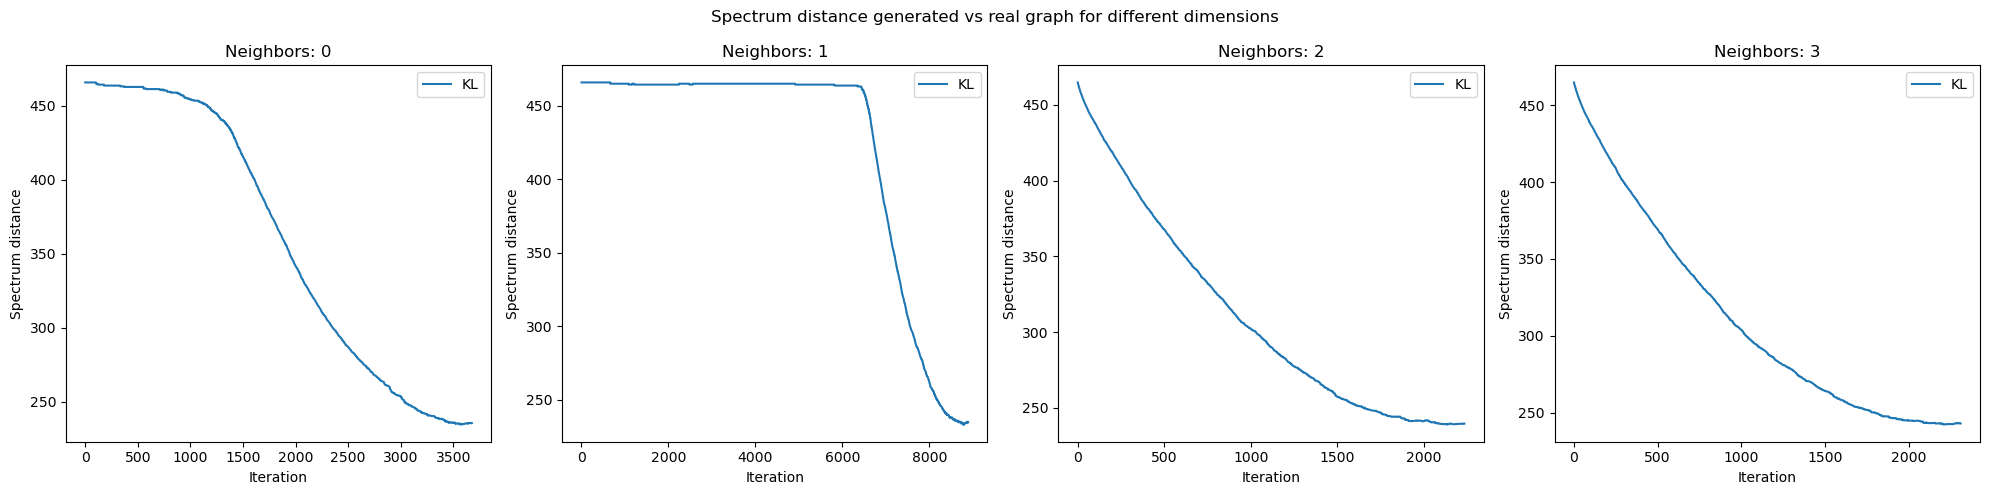


Distance type: KL
Best iteration for d = 0: 3576
Best iteration for d = 1: 8795
Best iteration for d = 2: 2134
Best iteration for d = 3: 2211


In [8]:
# Showing the spectrum evolution for all dimensions and distance types
fig, axes = plt.subplots(1, len(results_dict), figsize=(20, 5))
fig.suptitle('Spectrum distance generated vs real graph for different dimensions')

for d in range(len(results_dict)):
    ax = axes[d] if len(results_dict) > 1 else axes
    for dist_type in dist_types:
        spectrum_diffs = results_dict[d][dist_type]['spectrum_diffs']
        ax.plot(spectrum_diffs, label=dist_type)
    ax.set_title(f'Neighbors: {d}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Spectrum distance')
    ax.legend()

plt.tight_layout()
plt.show()

for dist_type in dist_types:
    print(f"\nDistance type: {dist_type}")
    for d in results_dict:
        print(f"Best iteration for d = {d}: {results_dict[d][dist_type]['best_iteration']}")

In [9]:
best_d = {}
best_final_diff = {}

for dist_type in dist_types:
    best_d[dist_type] = min(results_dict, key=lambda d: results_dict[d][dist_type]['spectrum_diffs'][-1])
    best_final_diff[dist_type] = results_dict[best_d[dist_type]][dist_type]['spectrum_diffs'][-1]
    print(f"For {dist_type}, the best dimension d is {best_d[dist_type]} with a final spectrum difference of {best_final_diff[dist_type]:.6f}")

# Optionally, we can also print the results for all dimensions for comparison
for dist_type in dist_types:
    print(f"\nFinal spectrum differences for all dimensions ({dist_type}):")
    for d in results_dict:
        final_diff = results_dict[d][dist_type]['spectrum_diffs'][-1]
        print(f"d = {d}: {final_diff:.6f}")


For KL, the best dimension d is 1 with a final spectrum difference of 234.704654

Final spectrum differences for all dimensions (KL):
d = 0: 235.620639
d = 1: 234.704654
d = 2: 239.650577
d = 3: 243.027632


In [10]:
print(len(results_dict))

dist_type = 'KL'

d = best_d[dist_type]
logit_graph = results_dict[d][dist_type]['logit_graph']
sigma = results_dict[d][dist_type]['sigma']
gic_values = results_dict[d][dist_type]['gic_values']
spectrum_diffs = results_dict[d][dist_type]['spectrum_diffs']
best_iteration = results_dict[d][dist_type]['best_iteration']

n_runs_graphs = 10
all_graphs_lg = results_dict[d][dist_type]['all_graphs']
all_graphs_lg = all_graphs_lg[-n_runs_graphs-1:-1] 
all_graphs_lg = [nx.from_numpy_array(graph) for graph in all_graphs_lg]

log_params = [sigma]*len(all_graphs_lg)

4


In [11]:
len(log_params), len(all_graphs_lg)

(10, 10)

In [28]:

selector = ms.GraphModelSelection(graph=nx.from_numpy_array(real_graph),
                                log_graphs=all_graphs_lg,
                                log_params=log_params,
                                #models=["ER", "WS", "GRG", "BA", "KR", "LG"],
                                models=["ER", "WS", "GRG", "BA", "LG"],
                                n_runs=n_runs_graphs,
                                parameters=[ {'lo': 0.01, 'hi': 1}, # ER
                                            {'lo': 0.01, 'hi': 1}, # WS k=8
                                            {'lo': 1, 'hi': 3},    # GRG
                                            {'lo': 1, 'hi': 5},    # BA
                                            #{'lo': 1, 'hi': 3},    # KR
                                            ]
                                )


#result = selector.select_model_avg_gic()
result = selector.select_model_avg_spectrum()

Testing the selected model for ER
ER result: {'param': 0.45, 'spectrum': array([0.02197802, 0.        , 0.        , 0.11062271, 2.21233211,
       2.40622711, 0.24884005, 0.        , 0.        , 0.        ])}
Testing the selected model for WS
WS result: {'param': 0.01, 'spectrum': array([0.33333333, 0.22222222, 0.11111111, 0.11111111, 0.77777778,
       1.77777778, 1.66666667, 0.        , 0.        , 0.        ])}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.03296703, 0.        , 0.        , 0.        , 0.52997558,
       4.43705739, 0.        , 0.        , 0.        , 0.        ])}
Testing the selected model for BA
BA result: {'param': 1.0, 'spectrum': array([0.64757446, 0.49177059, 0.27125228, 0.05531273, 1.006496  ,
       1.05057277, 0.05531273, 0.27125228, 0.49177059, 0.65868557])}
Testing the selected model for LG
LG result: {'param': [-7.000275540333576, -7.000275540333576, -7.000275540333576, -7.000275540333576, -7.000275540333576, -7.00027

In [33]:
# For the avg gic
#result_dict = {item['model']: {'param': clean_and_convert(item['param']), 'GIC': item['GIC']} for item in result['estimates']}
#min_gic_key = min(result_dict, key=lambda k: result_dict[k]['GIC']) # Get best fit
#model_names = result_dict.keys() 

# For the average spectrum
result_dict = {item['model']: {'param': clean_and_convert(item['param']), 'distance': item['distance']} for item in result['estimates']}
min_distance_key = min(result_dict, key=lambda k: result_dict[k]['distance']) # Get best fit
model_names = result_dict.keys()

In [36]:
model_names, min_distance_key, result_dict

(dict_keys(['ER', 'BA', 'LG', 'WS', 'GRG']),
 'ER',
 {'ER': {'param': 0.45, 'distance': 0.4864562951755457},
  'BA': {'param': 1.0, 'distance': 2.2149112793265675},
  'LG': {'param': -7.000275540333576, 'distance': 2.2149112793265675},
  'WS': {'param': 0.01, 'distance': 2.421610524189264},
  'GRG': {'param': 1.0, 'distance': 3.0884912982468085}})

# Graph Viz

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()
    return fig

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()
    return fig

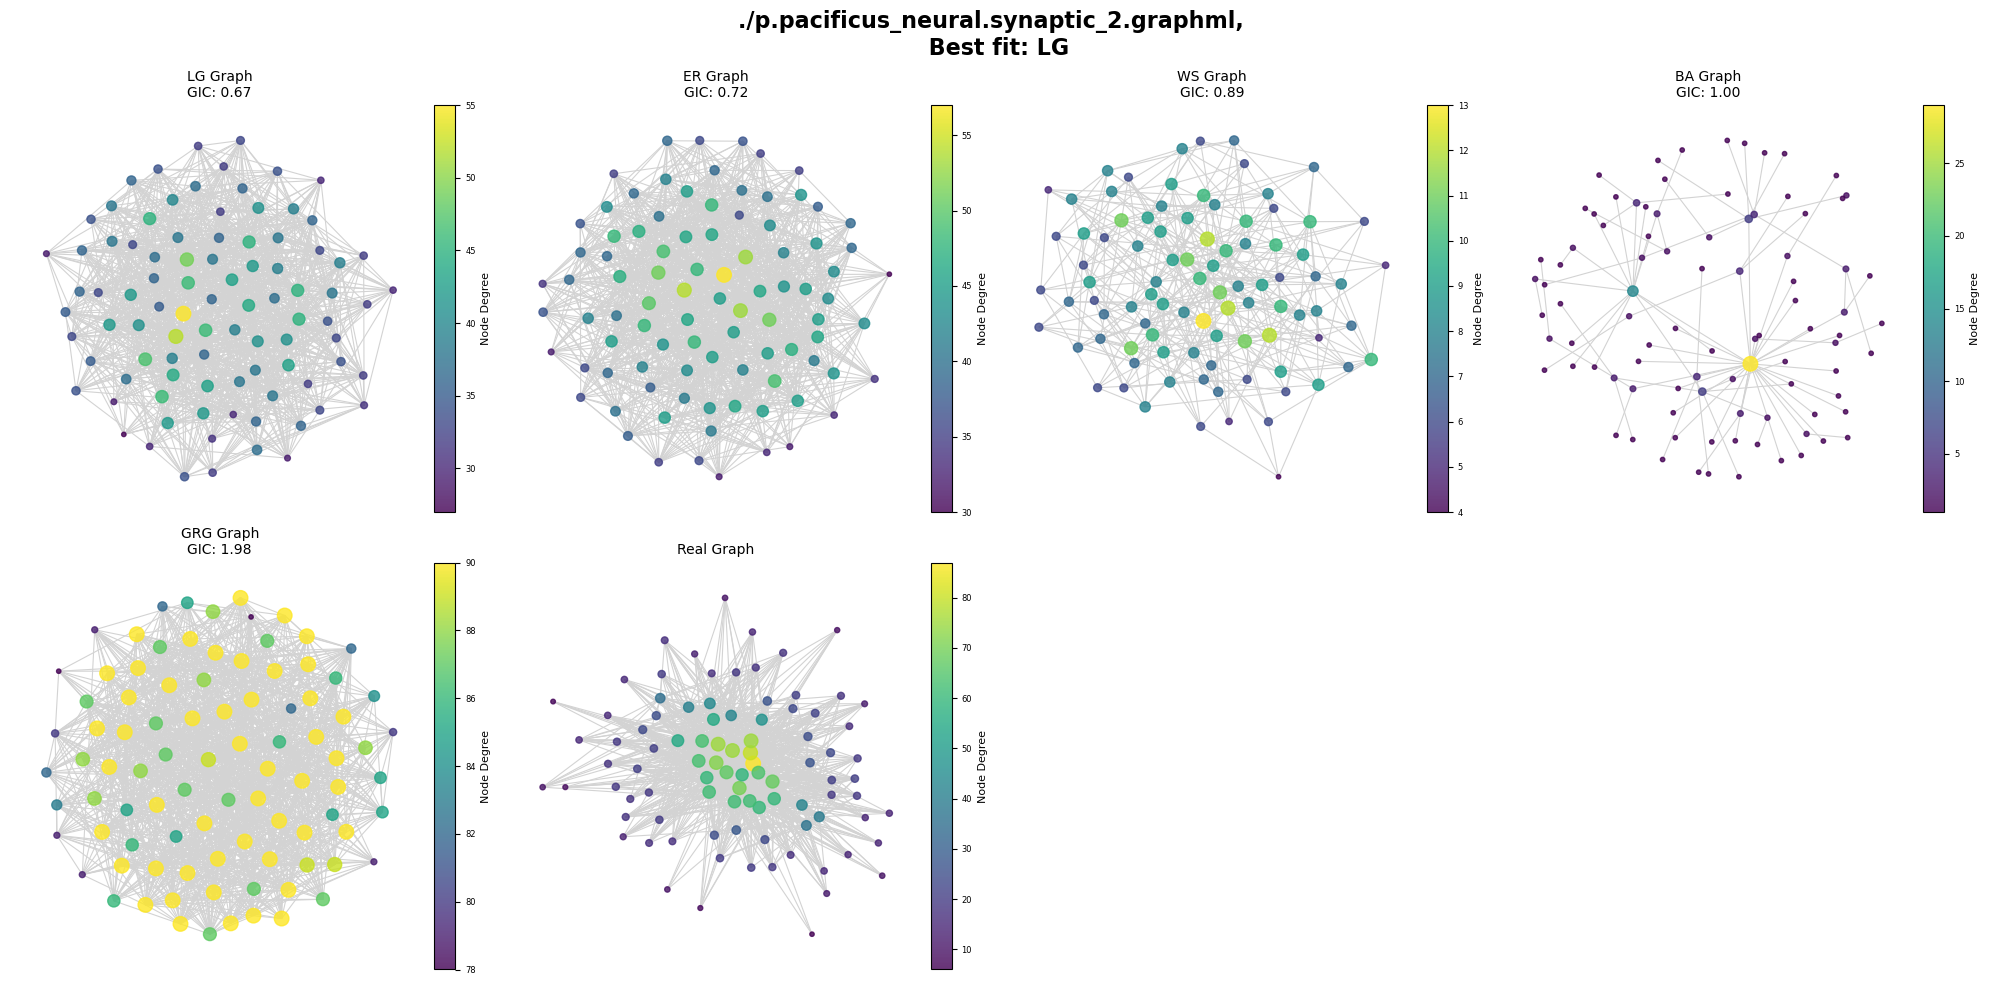

In [42]:


sim_graphs_dict = {}
for model in model_names:
    if model!='LG':
        func = selector.model_function(model_name=model)
        graph_sim = func(real_graph.shape[0], float(result_dict[model]['param']))
        sim_graphs_dict[model] = graph_sim
    elif model=='LG':
        sim_graphs_dict[model] = nx.from_numpy_array(logit_graph)

sim_graphs_dict['Real'] = nx.from_numpy_array(real_graph)


save_path=f'../images/imgs_connectomes/{connectomes[i]}.png'

if os.path.exists('../images/imgs_connectomes/')==False:
    os.makedirs('../images/imgs_connectomes/')
else:
    pass

fig = plot_graphs_in_matrix(sim_graphs_dict,
                            result_dict,
                            global_title=f'./{connectomes[i]}, \n Best fit: {min_gic_key}',
                            save_path=save_path)

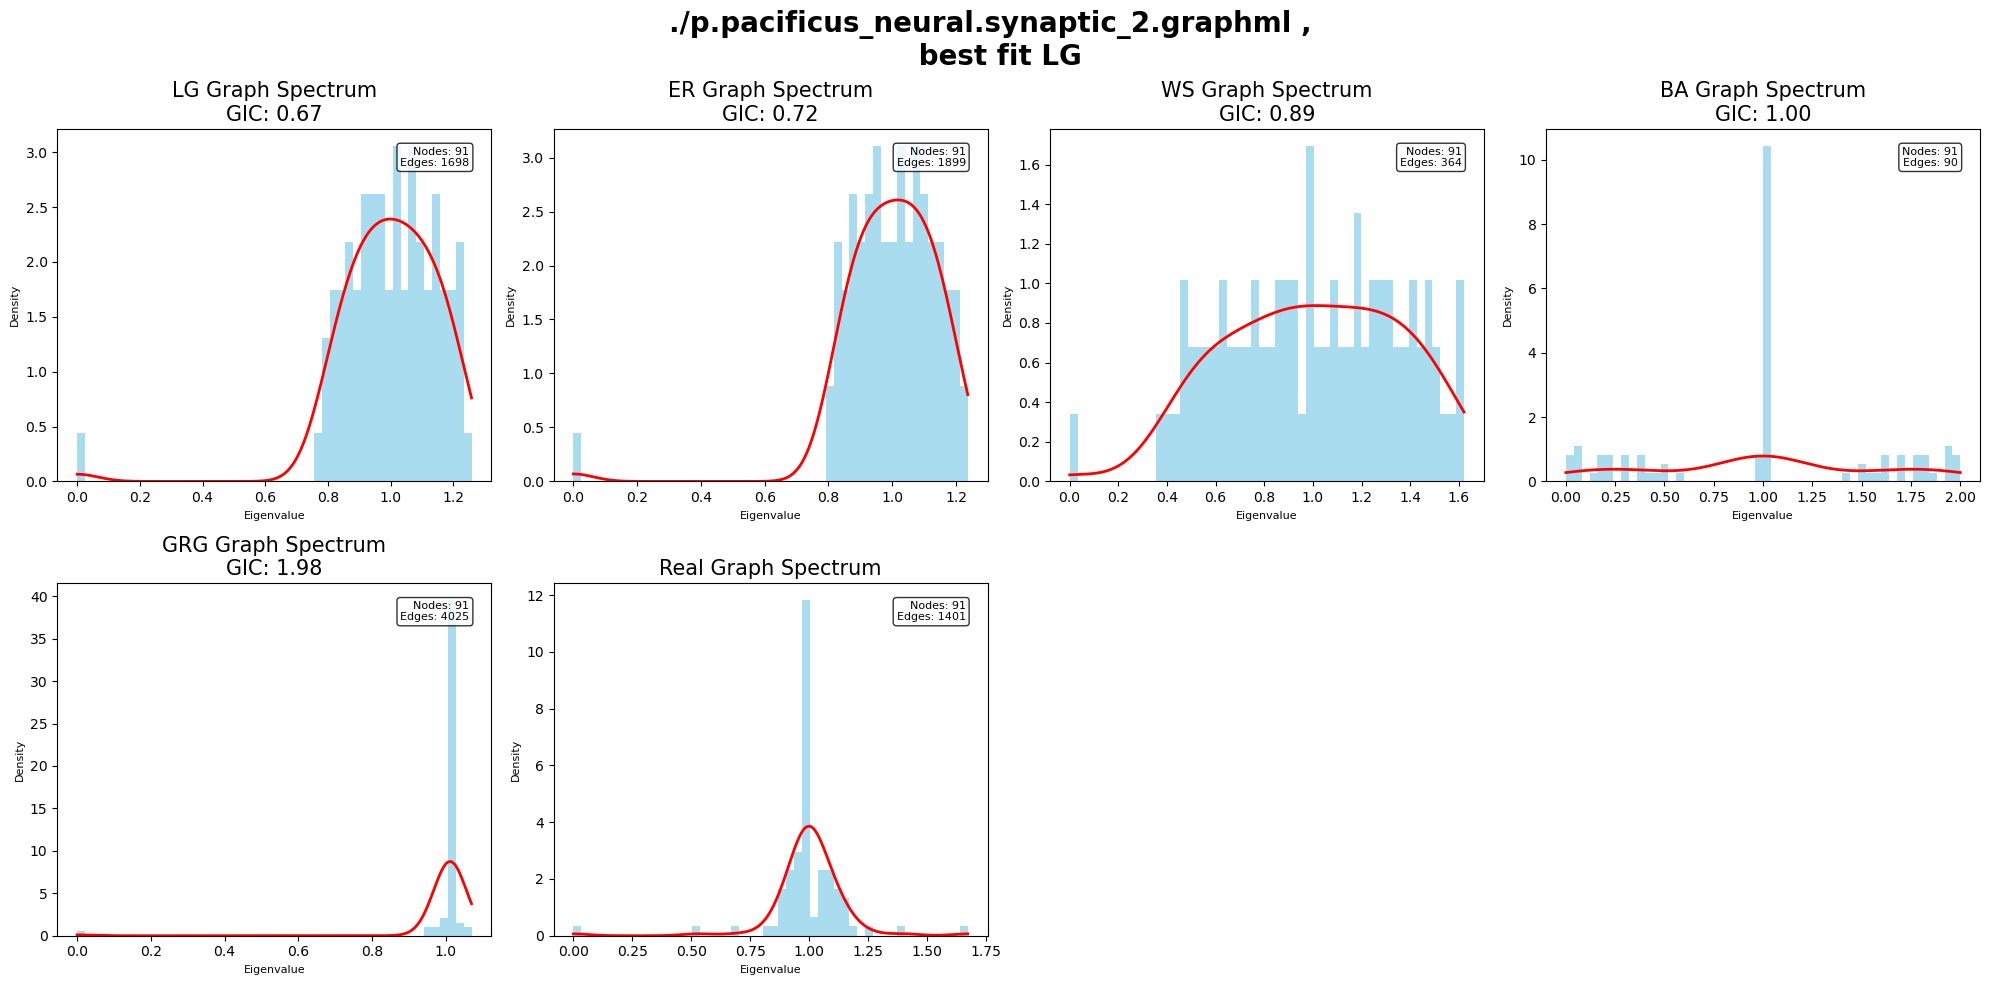

In [43]:
sim_graphs_dict = {}
for model in model_names:
    if model != 'LG':
        func = selector.model_function(model_name=model)
        graph_sim = func(real_graph.shape[0], float(result_dict[model]['param']))
        sim_graphs_dict[model] = graph_sim
    elif model == 'LG':
        sim_graphs_dict[model] = nx.from_numpy_array(logit_graph)

sim_graphs_dict['Real'] = nx.from_numpy_array(real_graph)

# Plot the spectrum for each graph model
fig = plot_spectra_in_matrix(sim_graphs_dict,
                         result_dict,
                         global_title=f'./{connectomes[i]} , \n best fit {min_gic_key}',
                         bins=50)

# Optionally save the figure
if os.path.exists('../images/imgs_spectra/') == False:
    os.makedirs('../images/imgs_spectra/')
else:
    pass

save_path = f'../images/imgs_spectra/spectra_{connectomes[i]}.png'
if save_path:
    fig.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

# Auto runs for multiple datasets

Processing connectome 1/18: p.pacificus_neural.synaptic_2.graphml
Graph shape: (50, 50)
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.204     
Date:               2024-08-27 19:32 AIC:              702.4648  
No. Observations:   1225             BIC:              717.7968  
Df Model:           2                Log-Likelihood:   -348.23   
Df Residuals:       1222             LL-Null:          -437.39   
Converged:          1.0000           LLR p-value:      1.9069e-39
No. Iterations:     15.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -3.8366     0.2074   -18.4947   0.0000   -4.2432   -3.4300
x1        0.0268     0.0030     8.8656   0.0000    0.0208    0.0327
x2  

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


	 Spectrum difference: 226.3970398565954
iteration: 247
	 Spectrum difference: 226.15924632346542
iteration: 248
	 Spectrum difference: 225.85121739500232
iteration: 249
	 Spectrum difference: 225.6157857586664
iteration: 250
	 Spectrum difference: 225.5738348734684
iteration: 251
	 Spectrum difference: 225.43876597136625
iteration: 252
	 Spectrum difference: 225.41659770912727
iteration: 253
	 Spectrum difference: 225.20681840875767
iteration: 254
	 Spectrum difference: 225.20681840875767
iteration: 255
	 Spectrum difference: 225.20681840875767
iteration: 256
	 Spectrum difference: 224.71353048853007
iteration: 257
	 Spectrum difference: 224.65519313087583
iteration: 258
	 Spectrum difference: 224.6217547723396
iteration: 259
	 Spectrum difference: 224.6217547723396
iteration: 260
	 Spectrum difference: 224.5600822259496
iteration: 261
	 Spectrum difference: 224.44752390191704
iteration: 262
	 Spectrum difference: 224.25897678589578
iteration: 263
	 Spectrum difference: 224.1196407151

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.219     
Date:               2024-08-27 19:32 AIC:              689.3503  
No. Observations:   1225             BIC:              704.6824  
Df Model:           2                Log-Likelihood:   -341.68   
Df Residuals:       1222             LL-Null:          -437.39   
Converged:          1.0000           LLR p-value:      2.7075e-42
No. Iterations:     16.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -4.2466     0.2718   -15.6216   0.0000   -4.7794   -3.7138
x1        0.0026     0.0005     5.3974   0.0000    0.0017    0.0035
x2        0.0052     0.0005    10.7587   0.0000    0.0042    0.0061

iteration: 0
	 Spectrum

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


	 Spectrum difference: 253.9502452320055
iteration: 314
	 Spectrum difference: 253.9502452320055
iteration: 315
	 Spectrum difference: 253.9502452320055
iteration: 316
	 Spectrum difference: 253.9502452320055
iteration: 317
	 Spectrum difference: 253.9502452320055
iteration: 318
	 Spectrum difference: 253.9502452320055
iteration: 319
	 Spectrum difference: 253.9502452320055
iteration: 320
	 Spectrum difference: 253.9502452320055
iteration: 321
	 Spectrum difference: 253.9502452320055
iteration: 322
	 Spectrum difference: 253.9502452320055
iteration: 323
	 Spectrum difference: 253.9502452320055
iteration: 324
	 Spectrum difference: 253.9502452320055
iteration: 325
	 Spectrum difference: 253.9502452320055
iteration: 326
	 Spectrum difference: 253.9502452320055
iteration: 327
	 Spectrum difference: 253.9502452320055
iteration: 328
	 Spectrum difference: 253.9502452320055
iteration: 329
	 Spectrum difference: 253.9502452320055
iteration: 330
	 Spectrum difference: 253.9502452320055
iterati

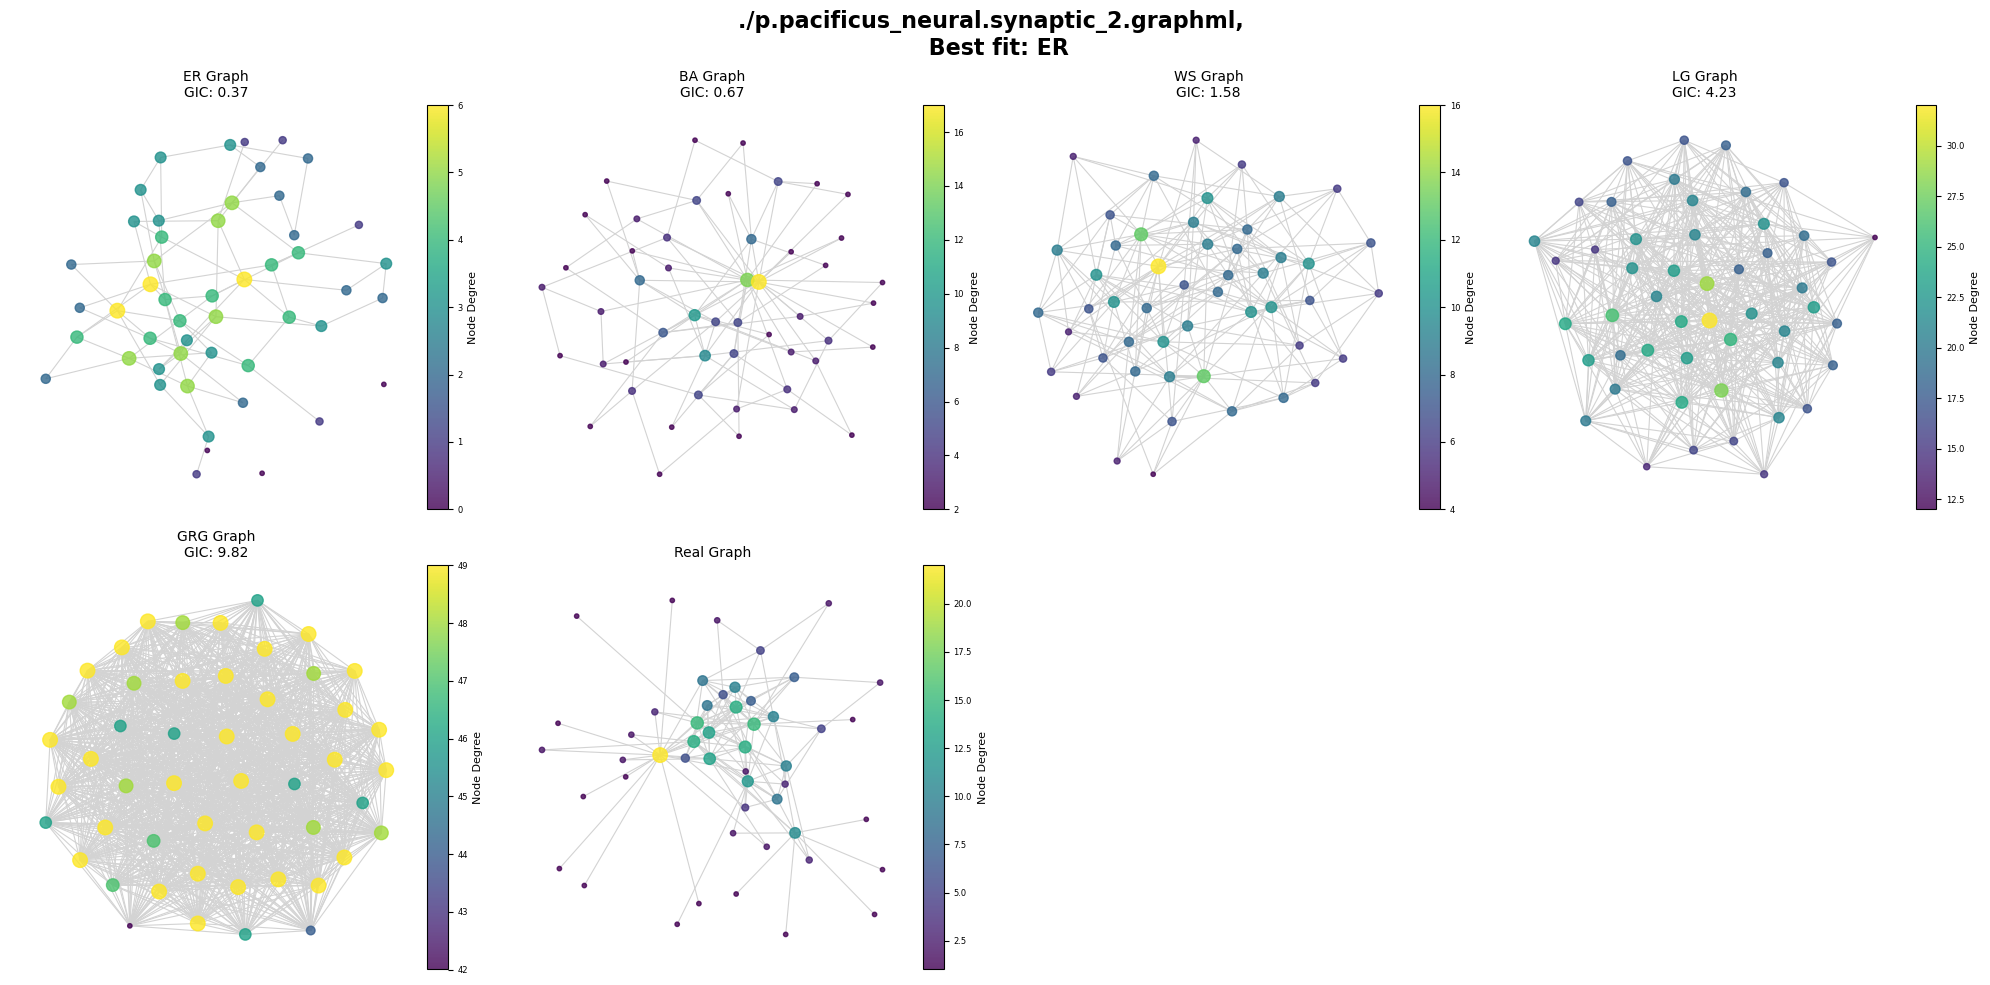

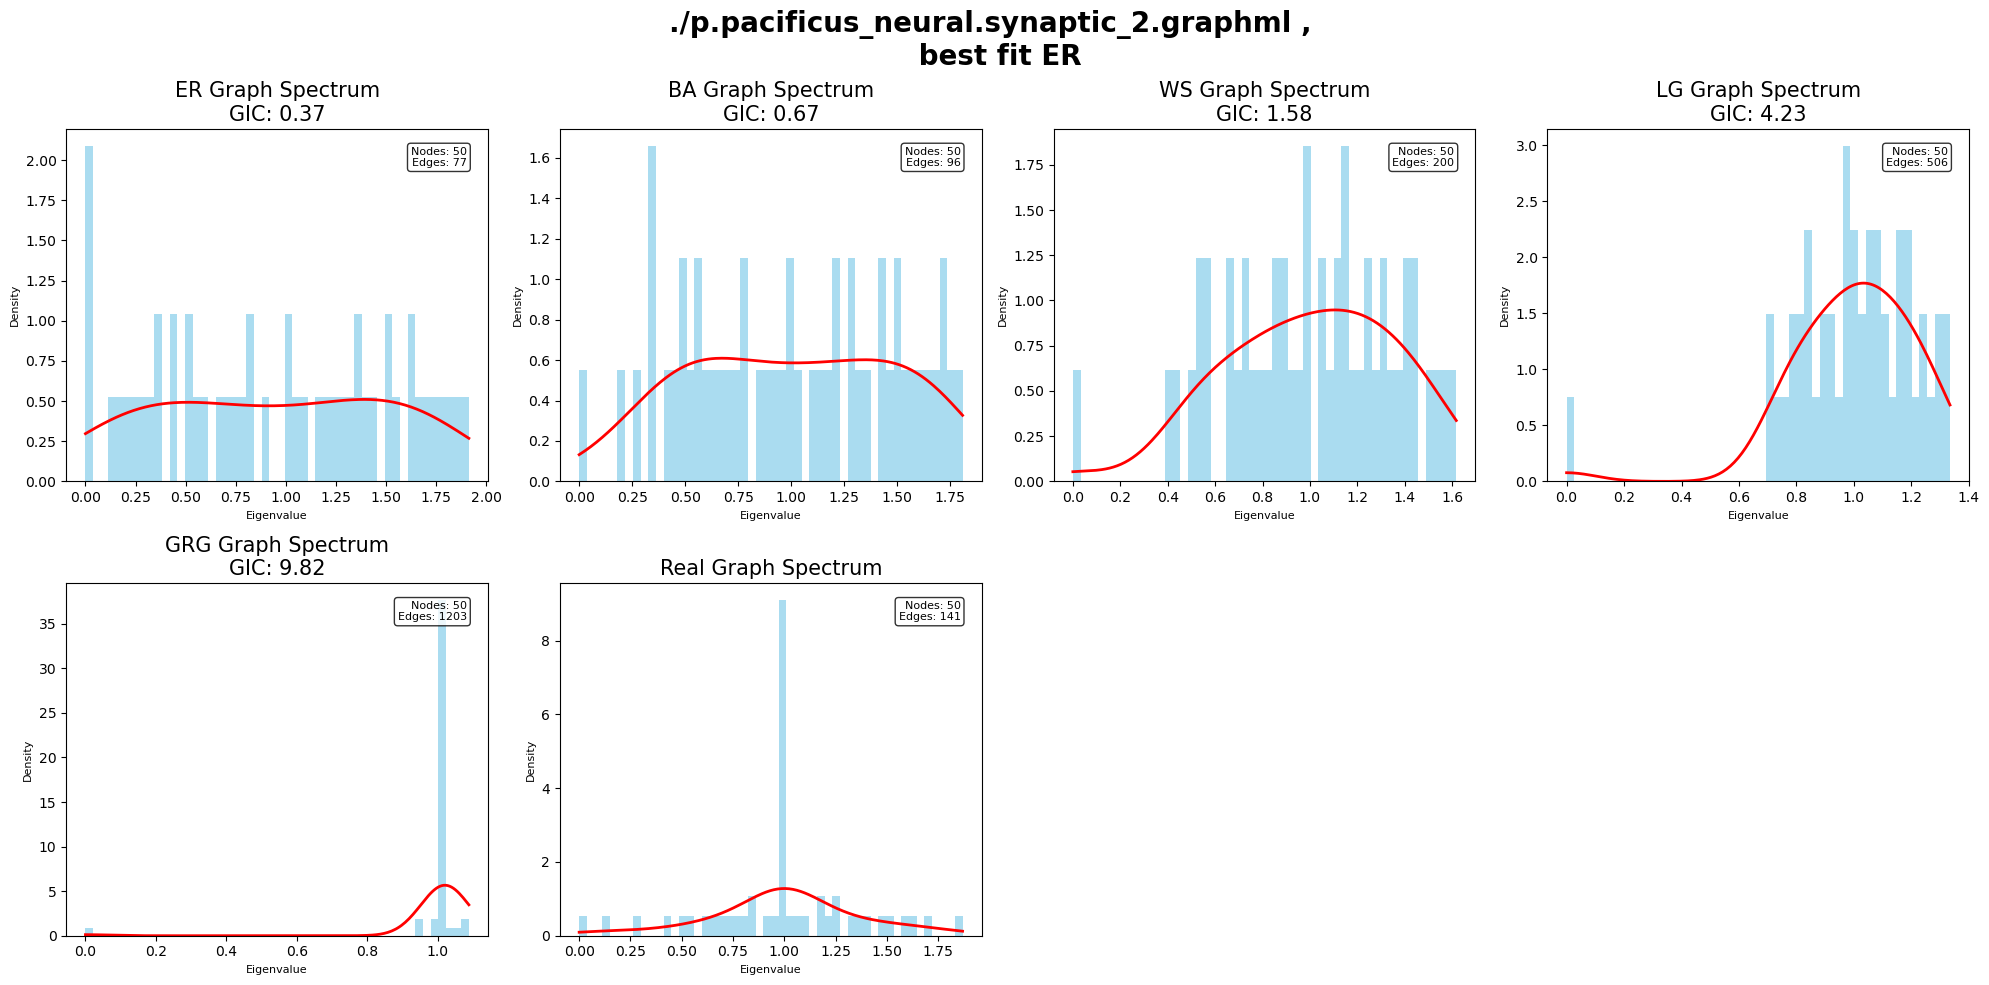

Completed processing for p.pacificus_neural.synaptic_2.graphml
--------------------
Processing connectome 2/18: rhesus_cerebral.cortex_1.graphml
Graph shape: (91, 91)
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.312    
Date:               2024-08-27 19:33 AIC:              3623.3445
No. Observations:   4095             BIC:              3642.2971
Df Model:           2                Log-Likelihood:   -1808.7  
Df Residuals:       4092             LL-Null:          -2630.8  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     17.0000          Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const   -4.2876     0.1304   -32.8906   0.0000   -4.5431   -4.0321
x1   

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


	 Spectrum difference: 465.71235757707774
iteration: 43
	 Spectrum difference: 465.71235757707774
iteration: 44
	 Spectrum difference: 465.71235757707774
iteration: 45
	 Spectrum difference: 465.71235757707774
iteration: 46
	 Spectrum difference: 465.71235757707774
iteration: 47
	 Spectrum difference: 465.71235757707774
iteration: 48
	 Spectrum difference: 465.71235757707774
iteration: 49
	 Spectrum difference: 465.71235757707774
iteration: 50
	 Spectrum difference: 465.71235757707774
iteration: 51
	 Spectrum difference: 465.71235757707774
iteration: 52
	 Spectrum difference: 465.71235757707774
iteration: 53
	 Spectrum difference: 465.71235757707774
iteration: 54
	 Spectrum difference: 465.71235757707774
iteration: 55
	 Spectrum difference: 465.71235757707774
iteration: 56
	 Spectrum difference: 465.71235757707774
iteration: 57
	 Spectrum difference: 465.71235757707774
iteration: 58
	 Spectrum difference: 465.71235757707774
iteration: 59
	 Spectrum difference: 465.71235757707774
iterat

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


	 Spectrum difference: 445.432048607807
iteration: 67
	 Spectrum difference: 445.20462027565213
iteration: 68
	 Spectrum difference: 445.01433924052816
iteration: 69
	 Spectrum difference: 444.7197794122479
iteration: 70
	 Spectrum difference: 444.6052084150074
iteration: 71
	 Spectrum difference: 444.254137954169
iteration: 72
	 Spectrum difference: 443.7404107466587
iteration: 73
	 Spectrum difference: 443.17094166451056
iteration: 74
	 Spectrum difference: 442.96343183985414
iteration: 75
	 Spectrum difference: 442.68306948614503
iteration: 76
	 Spectrum difference: 442.3878355912068
iteration: 77
	 Spectrum difference: 442.1647248747076
iteration: 78
	 Spectrum difference: 441.99369227328305
iteration: 79
	 Spectrum difference: 441.8144164216639
iteration: 80
	 Spectrum difference: 441.6093415301568
iteration: 81
	 Spectrum difference: 441.41052659352124
iteration: 82
	 Spectrum difference: 441.245981271773
iteration: 83
	 Spectrum difference: 441.09244573888435
iteration: 84
	 Spe

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.371    
Date:               2024-08-27 19:33 AIC:              3315.9794
No. Observations:   4095             BIC:              3334.9319
Df Model:           2                Log-Likelihood:   -1655.0  
Df Residuals:       4092             LL-Null:          -2630.8  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     16.0000          Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const    6.6045     0.2245    29.4234   0.0000    6.1646    7.0445
x1      -0.0022     0.0001   -28.7856   0.0000   -0.0023   -0.0020
x2      -0.0021     0.0001   -26.7860   0.0000   -0.0023   -0.0020

iteration: 0
	 Spectrum difference: 4

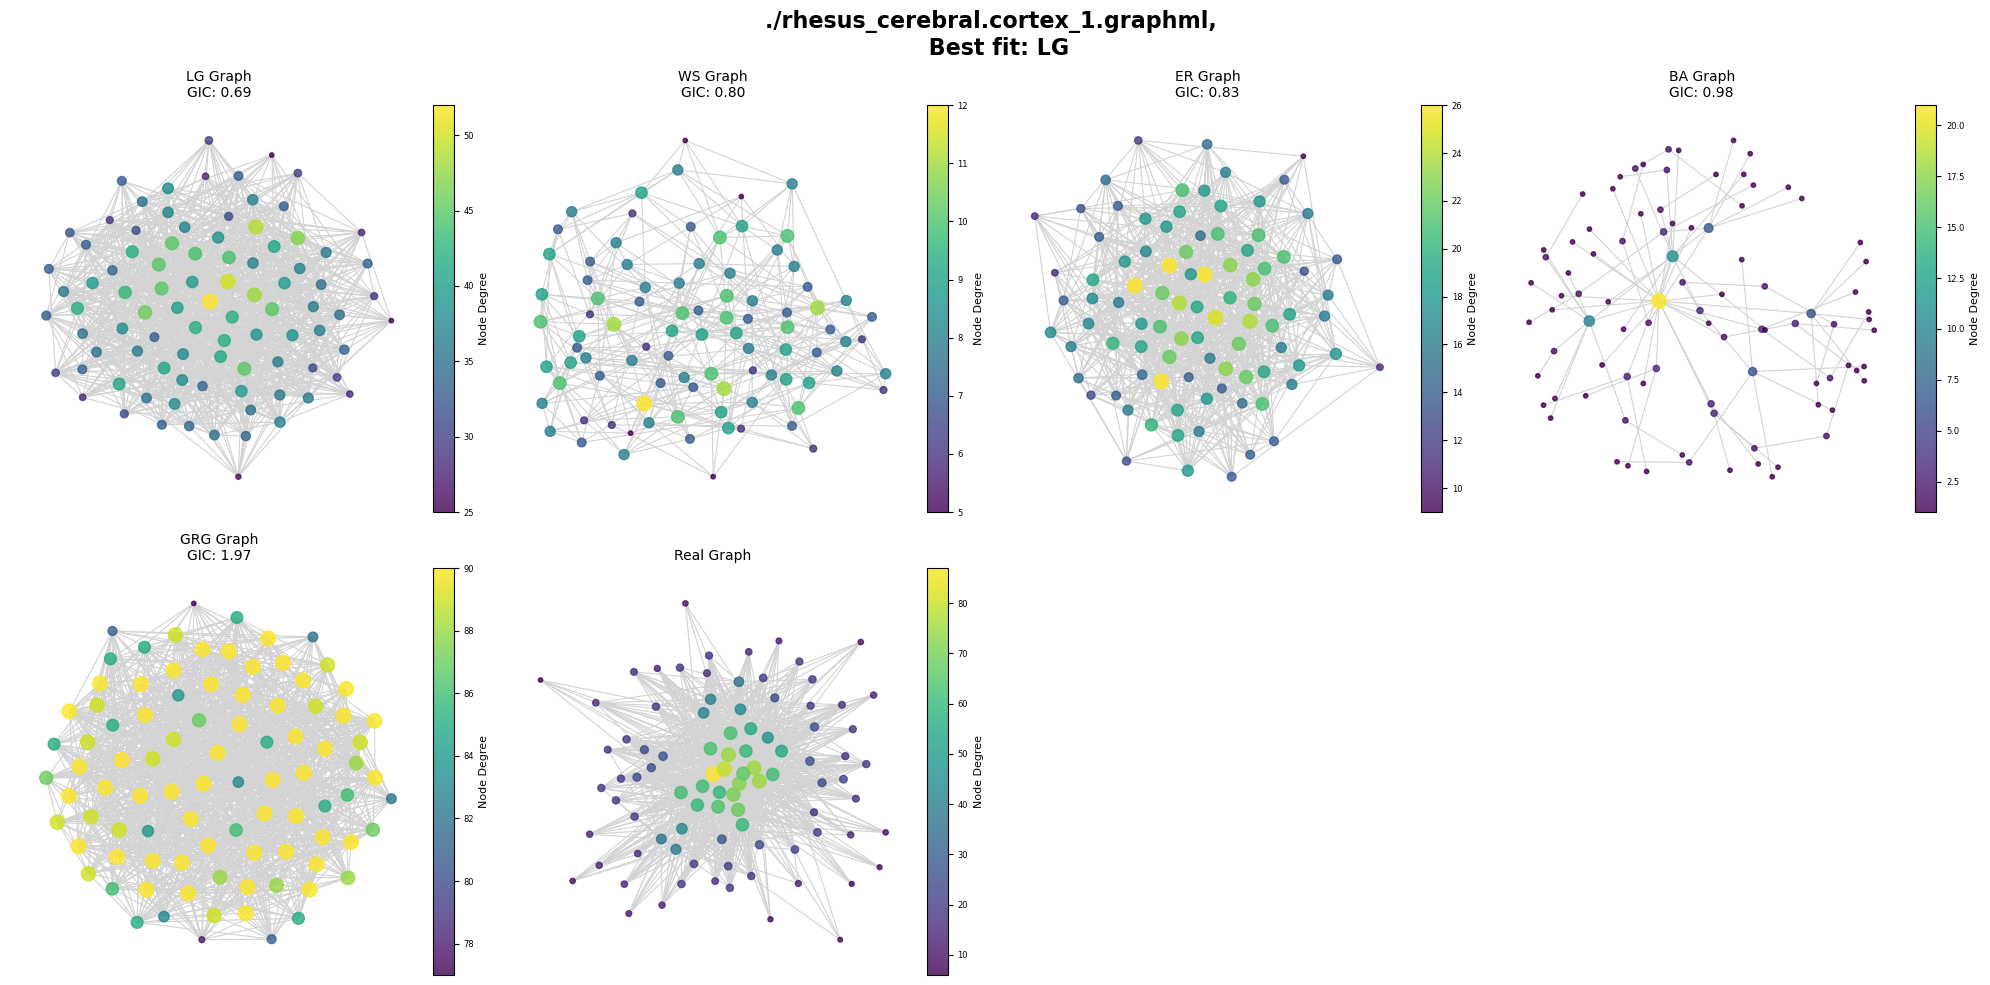

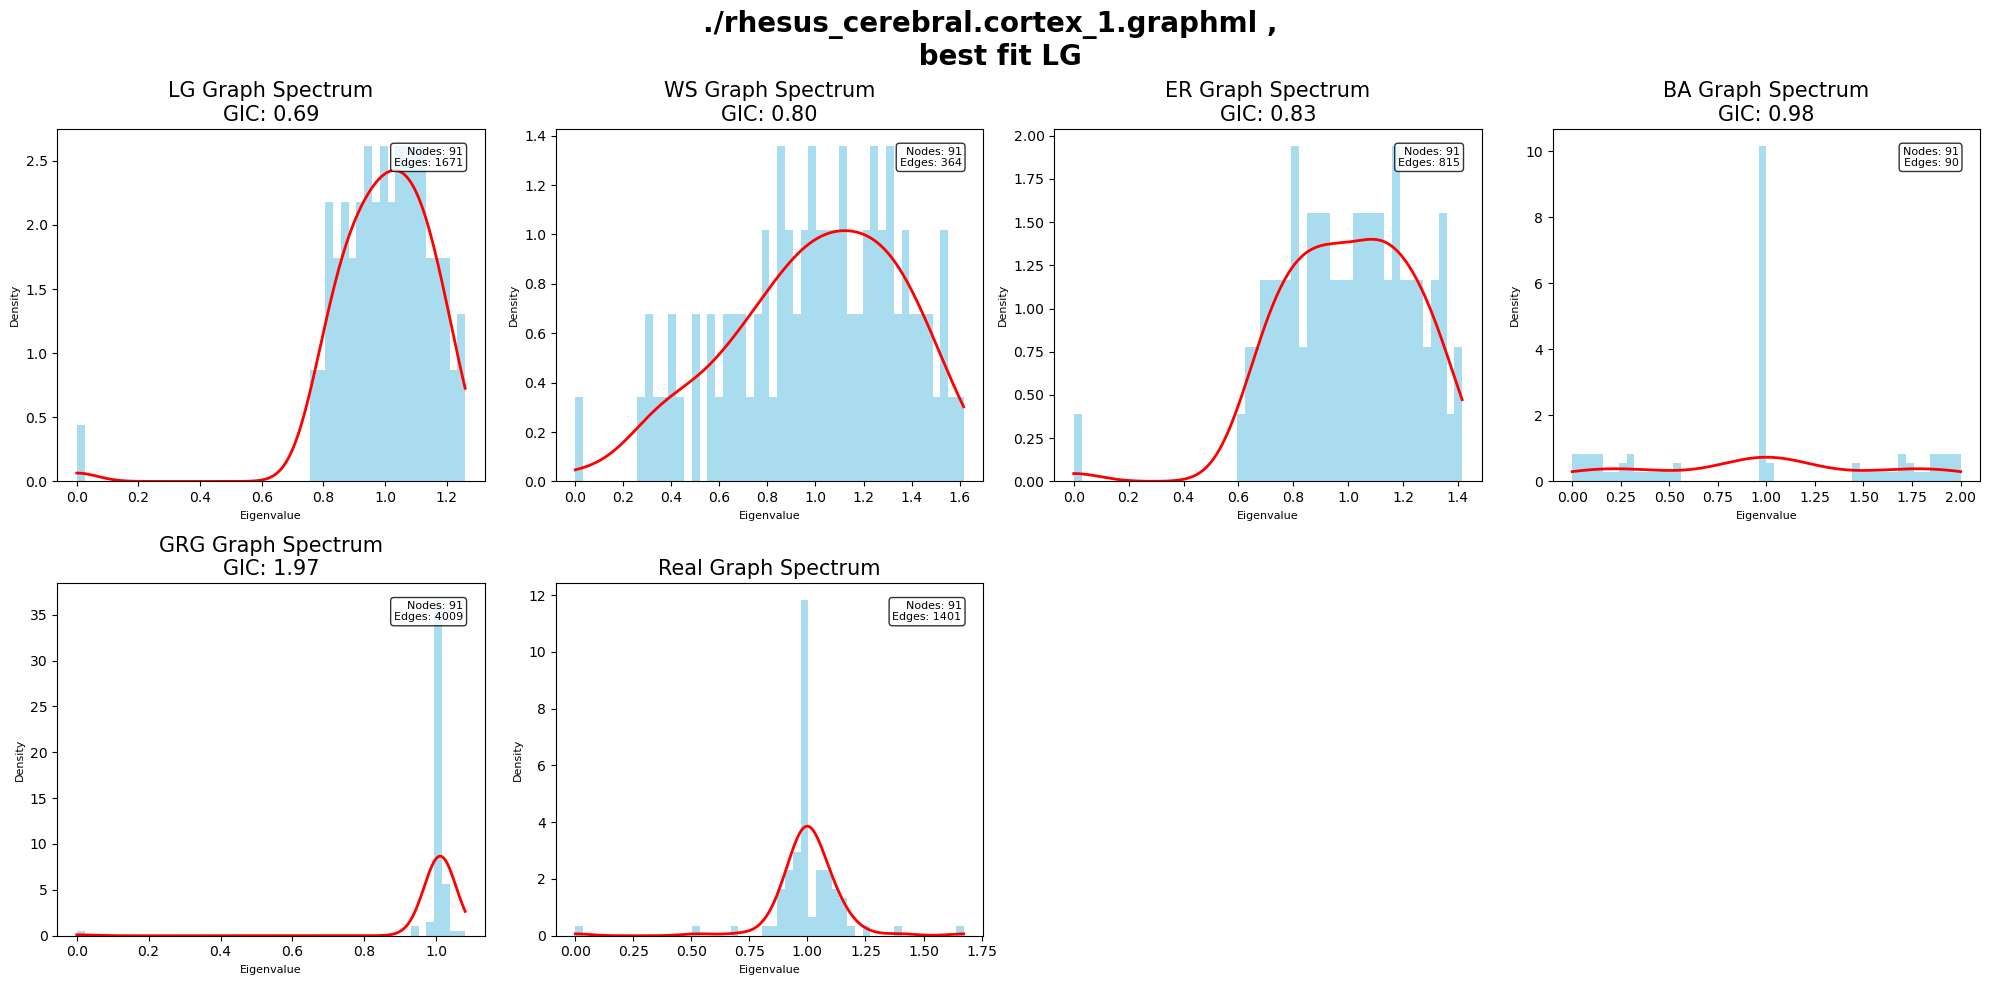

Completed processing for rhesus_cerebral.cortex_1.graphml
--------------------
Processing connectome 3/18: rattus.norvegicus_brain_1.graphml
Graph shape: (503, 503)


/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.718     
Date:               2024-08-27 19:33 AIC:              33848.4629
No. Observations:   126253           BIC:              33877.7010
Df Model:           2                Log-Likelihood:   -16921.   
Df Residuals:       126250           LL-Null:          -59974.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     20.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -6.5839     0.0394   -167.0025   0.0000   -6.6612   -6.5066
x1       0.0117     0.0001    145.9805   0.0000    0.0115    0.0118
x2       0.0119     0.0001    136.0039   0.0000    0.0117    0.0121

iteration: 0
	 Spectrum

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.469     
Date:               2024-08-27 19:43 AIC:              63732.7273
No. Observations:   126253           BIC:              63761.9654
Df Model:           2                Log-Likelihood:   -31863.   
Df Residuals:       126250           LL-Null:          -59974.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     20.0000          Scale:            1.0000    
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|    [0.025    0.975] 
------------------------------------------------------------------
const    -14.3677    0.0955  -150.4527  0.0000  -14.5549  -14.1805
x1         0.0002    0.0000   125.0543  0.0000    0.0002    0.0002
x2         0.0002    0.0000   117.7470  0.0000    0.0002    0.0002

iteration: 0
	 Spectrum diffe

: 

In [44]:
import os
import matplotlib.pyplot as plt

# Ensure the necessary directories exist
os.makedirs('../images/imgs_connectomes/', exist_ok=True)
os.makedirs('../images/imgs_spectra/', exist_ok=True)
os.makedirs('../images/search_neighbors/', exist_ok=True)

for i in range(len(connectomes)):
    print(f"Processing connectome {i+1}/{len(connectomes)}: {connectomes[i]}")
    
    real_graph = nx.read_graphml(datasets + connectomes[i])
    real_graph = nx.to_numpy_array(real_graph)

    print(f"Graph shape: {real_graph.shape}")

    dist_types = ['KL']
    results_dict = {}

    for d in range(4):
        results_dict[d] = {}
        for dist_type in dist_types:
            logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
                real_graph=nx.from_numpy_array(real_graph),
                d=d,
                warm_up=1000,
                n_iteration=20000,
                patience=100,
                dist_type=dist_type
            )
            
            results_dict[d][dist_type] = {
                'logit_graph': logit_graph,
                'sigma': sigma,
                'gic_values': gic_values,
                'spectrum_diffs': spectrum_diffs,
                'best_iteration': best_iteration,
                'all_graphs': all_graphs,
            }

    # Plot and save the spectrum evolution
    fig, axes = plt.subplots(1, len(results_dict), figsize=(20, 5))
    fig.suptitle(f'{connectomes[i]}: Spectrum distance generated vs real graph for different dimensions')

    for d in range(len(results_dict)):
        ax = axes[d] if len(results_dict) > 1 else axes
        for dist_type in dist_types:
            spectrum_diffs = results_dict[d][dist_type]['spectrum_diffs']
            ax.plot(spectrum_diffs, label=dist_type)
        ax.set_title(f'Neighbors: {d}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Spectrum distance')
        ax.legend()

    plt.tight_layout()
    plt.savefig(f'../images/search_neighbors/{connectomes[i]}.png', dpi=300, bbox_inches='tight')
    plt.close()

    for dist_type in dist_types:
        print(f"\nDistance type: {dist_type}")
        for d in results_dict:
            print(f"Best iteration for d = {d}: {results_dict[d][dist_type]['best_iteration']}")

    best_d = {}
    best_final_diff = {}

    for dist_type in dist_types:
        best_d[dist_type] = min(results_dict, key=lambda d: results_dict[d][dist_type]['spectrum_diffs'][-1])
        best_final_diff[dist_type] = results_dict[best_d[dist_type]][dist_type]['spectrum_diffs'][-1]
        print(f"For {dist_type}, the best dimension d is {best_d[dist_type]} with a final spectrum difference of {best_final_diff[dist_type]:.6f}")

    dist_type = 'KL'
    d = best_d[dist_type]
    logit_graph = results_dict[d][dist_type]['logit_graph']
    sigma = results_dict[d][dist_type]['sigma']
    gic_values = results_dict[d][dist_type]['gic_values']
    spectrum_diffs = results_dict[d][dist_type]['spectrum_diffs']
    best_iteration = results_dict[d][dist_type]['best_iteration']

    n_runs_graphs = 10
    all_graphs_lg = results_dict[d][dist_type]['all_graphs']
    all_graphs_lg = all_graphs_lg[-n_runs_graphs-1:-1] 
    all_graphs_lg = [nx.from_numpy_array(graph) for graph in all_graphs_lg]

    log_params = [sigma]*len(all_graphs_lg)

    selector = ms.GraphModelSelection(graph=nx.from_numpy_array(real_graph),
                                    log_graphs=all_graphs_lg,
                                    log_params=log_params,
                                    models=["ER", "WS", "GRG", "BA", "LG"],
                                    n_runs=n_runs_graphs,
                                    parameters=[{'lo': 0.01, 'hi': 1},  # ER
                                                {'lo': 0.01, 'hi': 1},  # WS k=8
                                                {'lo': 1, 'hi': 3},     # GRG
                                                {'lo': 1, 'hi': 5},     # BA
                                               ]
                                    )

    result = selector.select_model()
    result_dict = {item['model']: {'param': clean_and_convert(item['param']), 'GIC': item['GIC']} for item in result['estimates']}
    min_gic_key = min(result_dict, key=lambda k: result_dict[k]['GIC'])
    model_names = result_dict.keys()

    sim_graphs_dict = {}
    for model in model_names:
        if model != 'LG':
            func = selector.model_function(model_name=model)
            graph_sim = func(real_graph.shape[0], float(result_dict[model]['param']))
            sim_graphs_dict[model] = graph_sim
        elif model == 'LG':
            sim_graphs_dict[model] = nx.from_numpy_array(logit_graph)

    sim_graphs_dict['Real'] = nx.from_numpy_array(real_graph)

    # Plot and save graph visualizations
    fig = plot_graphs_in_matrix(sim_graphs_dict,
                                result_dict,
                                global_title=f'./{connectomes[i]}, \n Best fit: {min_gic_key}',
                                save_path=f'../images/imgs_connectomes/{connectomes[i]}.png')
    plt.close()

    # Plot and save spectrum visualizations
    fig = plot_spectra_in_matrix(sim_graphs_dict,
                                 result_dict,
                                 global_title=f'./{connectomes[i]} , \n best fit {min_gic_key}',
                                 bins=50,
                                 save_path=f'../images/imgs_spectra/spectra_{connectomes[i]}.png')
    plt.close()

    print(f"Completed processing for {connectomes[i]}")
    print("--------------------")

print("All connectomes processed.")